In [1]:
import pipeline_vsdi.io as io
import pipeline_vsdi.utils as ut

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
raw_file = '/Volumes/imaging1/morgane/neuronal_dataset/Cue_dataset/A02_Gaudi/day5/Block1_A02_d5_80101fr_125Hz_480x300_Bandpass_Cheby_high_0.5_9FHz_D_F0_.raw'
mask_file = '/Volumes/imaging1/morgane/neuronal_dataset/Cue_dataset/A02_Gaudi/day5/Mask.tif'
log_file  =
lfp_file = 

In [3]:
video = io.read_vsdi_file(raw_file,end_frame=1000)
mask = io.read_mask_tifffile(mask_file)

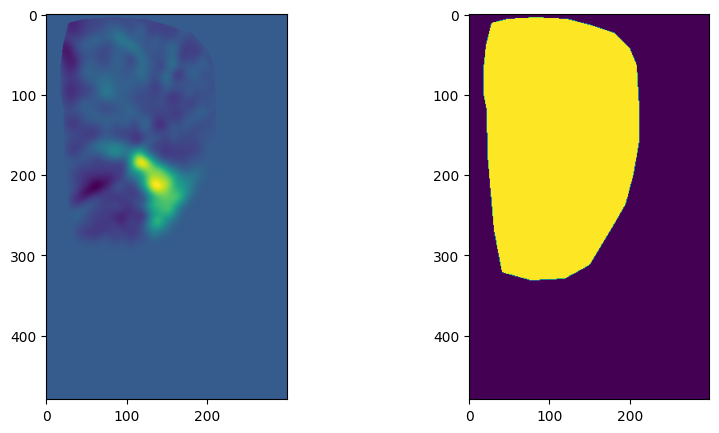

In [4]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(video[:,:,90])

plt.subplot(1,2,2)
plt.imshow(mask)


In [5]:
cropped_video,cropped_mask = ut.crop_to_bounding_box(video,mask)

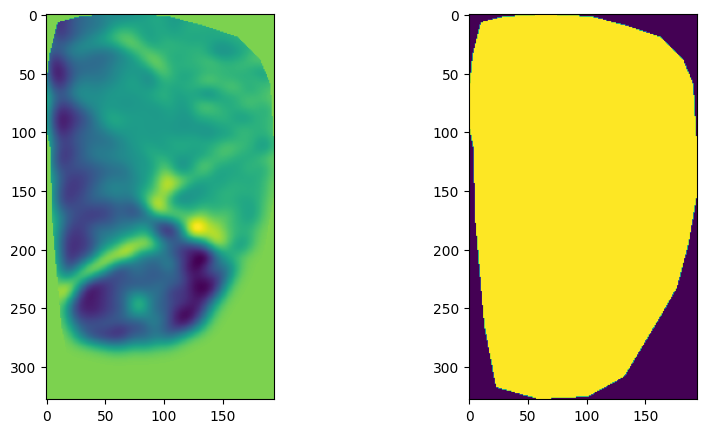

In [7]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(cropped_video[:,:,100])

plt.subplot(1,2,2)
plt.imshow(cropped_mask)